**Implementation to classify pest images by using transfer learning & fine tuning from a pre-trained network.** 

A *pre-trained model* is a saved network model that was previously trained on a large dataset.

The idea of **transfer learning** for image classification is that if we use a model which was trained on a really large and representative dataset, this model can serve as a base model to classify images which would save time (training time).

Approaches:
1. **feature extraction**: Representations learned by an already trained network to be used to extract meaningful features from new samples. Only new classifier shall be added, and trained on top of the pretrained model. This classification part shall replace the original classification with new classification for pest dataset.

2. **fine tuning** : Some of the top layers of the previously frozen model shall be unfreezed.  Both the new-top layer (to classify our specific datasets) and these last layers of the frozen model shall be then trained. We are doing this since only the last few layers of the base model extract top-level feature maps, the first convolution layers only extract basic features (edges, vertical/horizontal lines ...). This fine-tuning of the top feature representation in the base model allows to make them more specific for our classification task.

### Import Libraries

In [1]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os
import time, datetime

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as prepro_mob_v2
from tensorflow.keras.applications.resnet50 import preprocess_input as prepro_res50
from tensorflow.keras.applications.inception_v3 import preprocess_input as prepro_inc_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D

In [2]:
# load the backend
from tensorflow.keras import backend as K

# prevent Tensorflow memory leakage
K.clear_session()

In [3]:
!nvidia-smi

Mon Aug 30 07:28:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a id="content1"></a>
## 1. Introduction

<a id="content2"></a>
## 2. Define Helper Functions


##### Function to remove hidden files

In [4]:
def removeHiddenFile(data_dir):
    for files in os.listdir(data_dir):
     if files == ('.DS_Store'):
       os.remove(files)

#### Function to plot learning curve

In [5]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', xlabel='epochs', title='Training - Validation Accuracy', 
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

#### Function to plot learning curve for fine tuned models

In [6]:
def plot_history_fine_tuned(history, history_fine_tuned, epochs_0, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """
    initial_epochs=epochs_0
    acc = history.history['accuracy'][:epochs_0]
    acc += history_fine_tuned.history['accuracy']
    val_acc = history.history['val_accuracy'][:epochs_0]
    val_acc += history_fine_tuned.history['val_accuracy']
    
    loss = history.history['loss'][:epochs_0]
    loss += history_fine_tuned.history['loss']
    val_loss = history.history['val_loss'][:epochs_0]
    val_loss += history_fine_tuned.history['val_loss']
  
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([0.4,1.005]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [0,1] , label='fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

##### Function to print processing time

In [7]:
def printTime(start, end):
    diff = (end - start)
    diff_seconds = int(diff.total_seconds())
    minute_seconds, seconds = divmod(diff_seconds, 60)
    hours, minutes = divmod(minute_seconds, 60)
    hms = f"{hours}h {minutes}m {seconds}s"
    print(" \nTotal time: \n---------------\n",hms)

#### Function to print confusion matrix

In [8]:
def printCM(y_act,y_pred):
    mat = metrics.confusion_matrix(y_act, y_pred)
    df_mat = pd.DataFrame(mat, index=labels, columns=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Load and prepare image

In [9]:
def read_and_prep_images(img_paths, img_height,img_width):

    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array 
    return(img_array)



#### Define input path

In [10]:
input_path = r'Input_Dataset/'

In [11]:
print(os.getcwd())
print(os.listdir(input_path))

input_dir=input_path

/mnt/disks/user/project/Pests_Classification/Models
['Weevil', 'Oriental fruit fly', 'snail', 'Cydia pomonella', 'leafhopper', 'Gryllotalpa', 'stinkbug', 'Spodoptera litura', 'locust', 'Pieris rapae Linnaeus']


In [12]:
removeHiddenFile(input_dir)


<a id="content3"></a>
## 3. Data

### 3.1 Initialize Data path

In [13]:
path_data = input_dir
print(os.listdir(path_data))

['Weevil', 'Oriental fruit fly', 'snail', 'Cydia pomonella', 'leafhopper', 'Gryllotalpa', 'stinkbug', 'Spodoptera litura', 'locust', 'Pieris rapae Linnaeus']


In [14]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['Input_Dataset/Weevil',
 'Input_Dataset/Oriental fruit fly',
 'Input_Dataset/snail',
 'Input_Dataset/Cydia pomonella',
 'Input_Dataset/leafhopper',
 'Input_Dataset/Gryllotalpa',
 'Input_Dataset/stinkbug',
 'Input_Dataset/Spodoptera litura',
 'Input_Dataset/locust',
 'Input_Dataset/Pieris rapae Linnaeus']

In [15]:
data_dir = input_dir
data_dir

'Input_Dataset/'

### 3.2 Load data

In [16]:
data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    # files location of each pest
y = np.array(data['target'])       # target label of each pest
labels = np.array(data['target_names'])
    
print(f'Data files : \n {X}')
print(f'\n Target labels: {y}')   # numbers are corresponding to class label, 
                               # we have to change them to a vector of 10 elements
print(f'\n Label names : {labels}')
print(f'\n Number of files : {X.shape[0]}')

Data files : 
 ['Input_Dataset/snail/u=2637866814,2492862721&fm=26&gp=0.jpeg'
 'Input_Dataset/locust/u=4045076714,546731456&fm=26&gp=0.jpeg'
 'Input_Dataset/Gryllotalpa/t01ed90d6192101499d.jpeg' ...
 'Input_Dataset/Pieris rapae Linnaeus/th_id=OIP.31xugftXWYFx4UTcEYesIQHaFj&w=257&h=189&c=7&o=5&pid=1.jpeg'
 'Input_Dataset/locust/u=820882254,1907580936&fm=26&gp=0.jpeg'
 'Input_Dataset/Oriental fruit fly/th_id=OIP.gkL7fOV06Z1ENJ0-iZ7KwgHaHF&w=182&h=174&c=7&o=5&pid=1.jpeg']

 Target labels: [8 7 1 ... 3 7 2]

 Label names : ['Cydia pomonella' 'Gryllotalpa' 'Oriental fruit fly'
 'Pieris rapae Linnaeus' 'Spodoptera litura' 'Weevil' 'leafhopper'
 'locust' 'snail' 'stinkbug']

 Number of files : 5868


In [17]:
# Pest species number
df = pd.DataFrame({'classes': y})
print(df.shape)
df.head(10)

(5868, 1)


,classes
0,8
1,7
2,1
3,3
4,4
5,8
6,2
7,1
8,0
9,0


In [18]:
# associate names to species number
df['Pest class'] = df['classes'].astype('category')
df['Pest class'].cat.categories = labels
df.head(10)

,classes,Pest class
0,8,snail
1,7,locust
2,1,Gryllotalpa
3,3,Pieris rapae Linnaeus
4,4,Spodoptera litura
5,8,snail
6,2,Oriental fruit fly
7,1,Gryllotalpa
8,0,Cydia pomonella
9,0,Cydia pomonella


#### Check how the classes are distributed

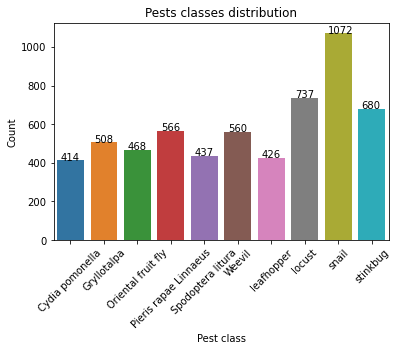

In [19]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Pest class", data=df)
ax.set(ylabel='Count', title='Pests classes distribution')
ax.tick_params(axis='x', rotation=45)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()))

### 3.3 Transform images to array

Load a few different images and transform them into numpy arrays.

In [20]:
image_size = 224     # standard value for MobileNet, MobileNetV2, 299 for MobileNetV2

X = np.array(read_and_prep_images(X, image_size,image_size))
print(X.shape)  # (num_images, height_size, width_size, depth=RGB)

(5868, 224, 224, 3)


##### Let's have a look at a few randomly picked pests.

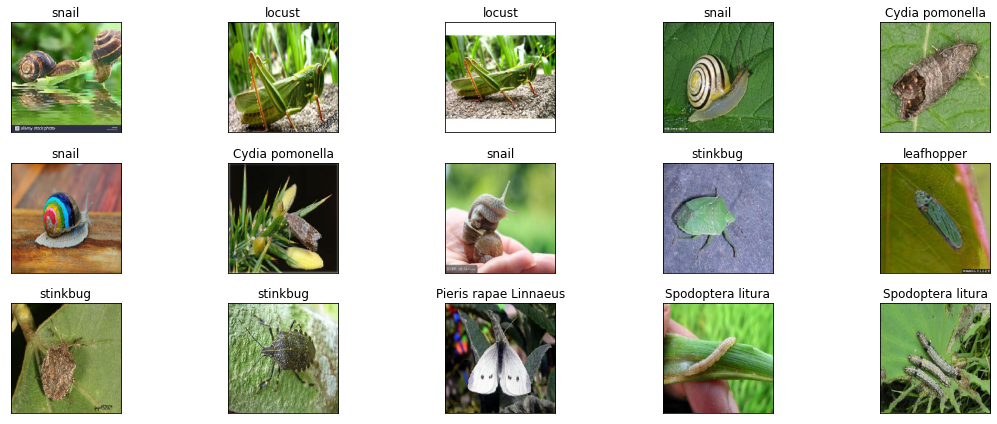

In [21]:
N = 15  # number of pests to display
fig, axes = plt.subplots(3, 5, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):    
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f'{labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()


### 3.4 Apply Label encoding

In [22]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} \n  {labels}')

Number of classes: 10 
  ['Cydia pomonella' 'Gryllotalpa' 'Oriental fruit fly'
 'Pieris rapae Linnaeus' 'Spodoptera litura' 'Weevil' 'leafhopper'
 'locust' 'snail' 'stinkbug']


Labels are the 10 classes number (from 0 to 9). Thus, we need to encode these labels to one-hot vectors. For instance, an image of a snail should have a label 8 and a corresponding **y** = [0,0,0,0,0,0,0,0,1,0].

In [23]:
y = to_categorical(y, num_classes)
print(y.shape)

(5868, 10)


### 3.5 Split training and validation set

Split dataset into training, validation and testing set. This ensures that there are no bias: the model is trained on images with known labels, then we test our model accuracy on the validation dataset on images that our model did not see before. Finally, we compute the accuracy on the test dataset.

In [24]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, 
                                                test_size=0.2, random_state=28)
print(f'Train dataset before train, val split: {Xtrain.shape[0]}')


Xtrain, Xval,ytrain,yval = train_test_split(Xtrain, ytrain, test_size=0.2,
                                            shuffle=True, random_state=28)
print(f'\nTrain dataset after train, val split: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset before train, val split: 4694

Train dataset after train, val split: 3755
Validation dataset: 939
Test dataset: 1174


### 3.6  Augment Data

Data augmentation technique is used to ovoid any overfitting. We add artificially generated data/images into our dataset. These images are created by altering the dataset with tiny transformations to reproduce very similar images. 

Example, we rotate of a few degree an image, de-center, zoom in or out a little bit etc. The common augmentation techniques are horizontal/vertical flips, rotations, translations, rescaling, random crops, adjust brightness etc

In [25]:
print(os.getcwd())

/mnt/disks/user/project/Pests_Classification/Models


In [26]:
image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
#         preprocessing_function = prepro_res50,
        rescale=1./255,           # rescale pixel values [0,255] to [0,1]
        horizontal_flip=True,     # random horizontal flip
        width_shift_range=0.2,    # random shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # random shift images vertically (fraction of total height)
        zoom_range=0.2,          # random zoom image
        rotation_range=20,       # random rotation
        shear_range=0.2)         # shear transfo

test_datagen = ImageDataGenerator(
        rescale=1./255)
      
train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)              # already shuffled

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)   

#### Checking Data Augmentation functioning

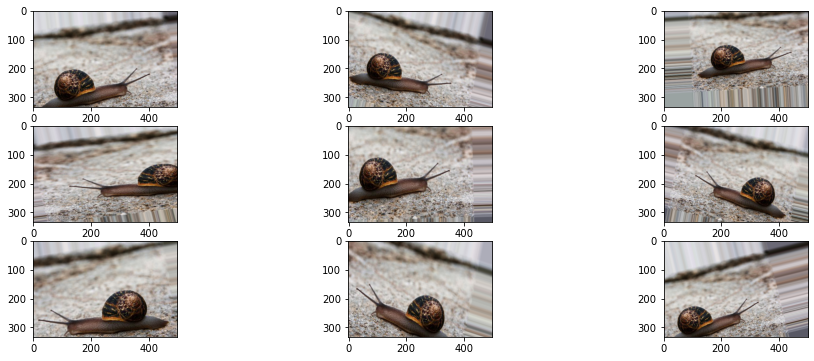

In [27]:

# example of image augmentation
from numpy import expand_dims
from matplotlib import pyplot

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    # files location of each pest

# load the image

img = load_img(X[5])
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
        horizontal_flip=True,     
        width_shift_range=0.2,    
        height_shift_range=0.2,   
        zoom_range=0.2,          
        rotation_range=20,       
        shear_range=0.2
)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot

axes = pyplot.subplots(3, 3, figsize=(16,6))
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    pyplot.imshow(image)
# show the figure
pyplot.show()


In [28]:
# release memory
del X

In [29]:
# release memory
del y

<a id="content4"></a>
## 4. Models

### 4.1 Parameter details 


`Accuracy function` -  used to evaluate the performance of the model

`Loss function` - used to measure how the model performs on data with known labels. It tells us how poorly the model performs in a supervised system. Since this is multi-label classification, we use *categorical_crossentropy* for loss function

Optimizer function - used in order to minize the loss function by changing model parameters (weighs values, filters kernel values etc.). 

Optimizer -  `RMSprop` one of the commonly used algorithms for CNNs

`Learning Rate (*LR*)`:
Deep networks can take time for the optimizer to converge, so we will be using an annealing method of the learning rate (*LR*).

The *LR* is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. A high *LR* correspond to big steps and thus the convergence is faster. However, in that case the sampling is not really efficient since the optimizer do not fall especially in the right minima. A low *LR* means the optimizer will probably find the right local minima but it will take a lot of time. 

The idea here is to start from a low value but not so low and then decrease the *LR* along the training to reach efficiently the global minimum of the loss function. 

The `ReduceLROnPlateau` method allows to choose to reduce the *LR* by a coefficient (using 70%) if the accuracy has not improved after a number of epochs (3 for this).


The `EarlyStopping` method - used to control the training time. Stop if the accuracy has not improved after 10epochs 

The `ModelCheckpoint` - used for monitoring the best found weights during the training.

### 4. 2 Define the model

### 4.2.1 Feature extraction
Freeze the convolutional base and add a classifier on top of it and train this top-level classifier.

In [30]:
# Load the MobileNetV2 model excluding the final layers , done by making 'include_top=False'
import tensorflow as tf
img_shape = (image_size, image_size, 3)

start = datetime.datetime.now()
base_model = MobileNetV2(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
end = datetime.datetime.now()

base_model.trainable = False
    
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [31]:
print('Time taken to load MobileNetV2 model:')
printTime(start,end)

Time taken to load MobileNetV2 model:
 
Total time: 
---------------
 0h 0m 2s


In [32]:
# for idx in range(len(base_model.layers)):
print(base_model.get_layer(index = 100).name)

block_11_expand_relu


In [33]:
base_model.output_shape

(None, 7, 7, 1280)

Now, we need to generate predictions from the block of features, average over the spatial locations, using a `GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image. Finally, add some  `Dense` layers and a final Dense layer with 10 units corresponding to each classes of the pests.

In [34]:
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(512,activation='relu'),
                    Dense(num_classes, activation='softmax')
                   ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 661,002
Non-trainable params: 2,257,984
_________________________________________________________________


Note that only ~ 0.6mn parameters will be trained

### Parameters

In [35]:
# callbacks 
weight_path = '{}_best_weights.hdf5'.format('Saved_Models_Folder/MobileNetV2_RMSprop')
checkpoint = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)

# set a learning rate annealer
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.7, min_lr=0.00001)
    
# early stop if not improvement of accuracy after 5 epochs
early_stop = EarlyStopping(patience=10, verbose=1) 
    
callbacks = [checkpoint, lrr] 

# Optimizer
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

checkpoint_filepath1 ="Saved_Models_Folder/best_MobileNetV2_RMSprop_feature_Extractor_model.hdf5"
checkpoint_filepath2 = "Saved_Models_Folder/best_MobileNetV2_RMSprop_fine_Tuned_model.hdf5"
checkpoint_filepath3 = "Saved_Models_Folder/best_MobileNetV2_RMSprop_further_fine_Tuned_model.hdf5"

### Train the Feature extraction model

In [36]:
batch_size = 32
epochs_0 = 20
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

start = datetime.datetime.now()
history = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,  
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)
end = datetime.datetime.now()


Epoch 1/20
117/117 [==============================] - 87s 523ms/step - loss: 1.3002 - accuracy: 0.6590 - val_loss: 0.4491 - val_accuracy: 0.8405

Epoch 00001: val_accuracy improved from -inf to 0.84052, saving model to Saved_Models_Folder/MobileNetV2_RMSprop_best_weights.hdf5
Epoch 2/20
117/117 [==============================] - 38s 321ms/step - loss: 0.4442 - accuracy: 0.8574 - val_loss: 0.4631 - val_accuracy: 0.8707

Epoch 00002: val_accuracy improved from 0.84052 to 0.87069, saving model to Saved_Models_Folder/MobileNetV2_RMSprop_best_weights.hdf5
Epoch 3/20
117/117 [==============================] - 37s 317ms/step - loss: 0.3819 - accuracy: 0.8830 - val_loss: 0.5004 - val_accuracy: 0.8685

Epoch 00003: val_accuracy did not improve from 0.87069
Epoch 4/20
117/117 [==============================] - 37s 317ms/step - loss: 0.3417 - accuracy: 0.8948 - val_loss: 0.3959 - val_accuracy: 0.8858

Epoch 00004: val_accuracy improved from 0.87069 to 0.88578, saving model to Saved_Models_Folder/

In [37]:
printTime(start,end)

 
Total time: 
---------------
 0h 13m 11s



 ------ Learning curve - MobileNetV2 TL as Feature extractor ------ 


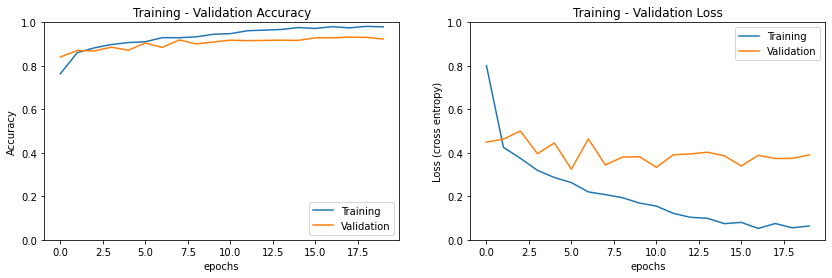

In [38]:
print("\n ------ Learning curve - MobileNetV2 TL as Feature extractor ------ ")
plot_history(history, loss_max=1)

###  Evaluate

In [39]:
# Generator for test dataset
datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      #  shuffled was already during splitting into train, valid, test


In [40]:

# Evaluation on the test dataset
start = datetime.datetime.now()
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
end = datetime.datetime.now()
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.40
Test accuracy: 91.57%


In [41]:
printTime(start,end)

 
Total time: 
---------------
 0h 0m 24s


###   Save model

In [42]:
model.save(checkpoint_filepath1)

###  Predict

In [43]:
import seaborn as sns
from sklearn import metrics

start = datetime.datetime.now()
pred = model.predict(eval_datagen, verbose=1)
end = datetime.datetime.now()

# get most likely class
y_pred = pred.argmax(axis=1)
y_act = ytest.argmax(axis=1)


37/37 [==============================] - 2s 38ms/step


In [44]:
printTime(start,end)

 
Total time: 
---------------
 0h 0m 2s


#### Confusion Matrix - Feature extraction


 ------ Confusion Matrix - MobileNetV2 TL as Feature extractor ------ 


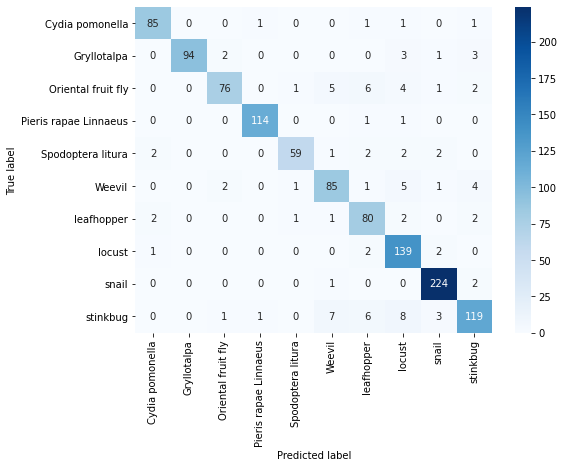

In [45]:
print("\n ------ Confusion Matrix - MobileNetV2 TL as Feature extractor ------ ")
printCM(y_act,y_pred)

#### Classification report - Feature extraction

In [46]:
print("\n ------ Classification Report - MobileNetV2 TL as Feature extractor ------")
print(metrics.classification_report(y_act, y_pred))


 ------ Classification Report - MobileNetV2 TL as Feature extractor ------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        89
           1       1.00      0.91      0.95       103
           2       0.94      0.80      0.86        95
           3       0.98      0.98      0.98       116
           4       0.95      0.87      0.91        68
           5       0.85      0.86      0.85        99
           6       0.81      0.91      0.86        88
           7       0.84      0.97      0.90       144
           8       0.96      0.99      0.97       227
           9       0.89      0.82      0.86       145

    accuracy                           0.92      1174
   macro avg       0.92      0.91      0.91      1174
weighted avg       0.92      0.92      0.92      1174



### 4.2.2 Fine Tuning the model

Unfreeze some of the top layers of the base model and train all those and the top layer classifier.

In [47]:
base_model.trainable = True

# print number of layers are in the base model
len(base_model.layers)

154

In [48]:
# Fine-tune from this layer onwards
fine_tuning = 100

# Freeze all the layers before fine_tuned_ind
for layer in base_model.layers[:fine_tuning]:
    layer.trainable =  False
base_model.summary()



Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [49]:
# Updated learning rate
opt = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.2)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,522,442
Non-trainable params: 396,544
_________________________________________________________________


### Training the fine tuned model

In [51]:
fine_tuned_epochs = 20
total_epochs = epochs_0 + fine_tuned_epochs

start = datetime.datetime.now()
history_fine_tuned = model.fit_generator(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)
end = datetime.datetime.now()


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 20/40
117/117 [==============================] - 67s 431ms/step - loss: 0.4116 - accuracy: 0.8940 - val_loss: 0.4284 - val_accuracy: 0.9246

Epoch 00020: val_accuracy did not improve from 0.93211
Epoch 21/40
117/117 [==============================] - 37s 313ms/step - loss: 0.2473 - accuracy: 0.9234 - val_loss: 0.4214 - val_accuracy: 0.9267

Epoch 00021: val_accuracy did not improve from 0.93211
Epoch 22/40
117/117 [==============================] - 38s 320ms/step - loss: 0.2761 - accuracy: 0.9267 - val_loss: 0.4177 - val_accuracy: 0.9278

Epoch 00022: val_accuracy did not improve from 0.93211
Epoch 23/40
117/117 [==============================] - 37s 317ms/step - loss: 0.2559 - accuracy: 0.9307 - val_loss: 0.4185 - val_accuracy: 0.9278

Epoch 00023: val_accuracy did not improve from 0.93211
Epoch 24/40
117/117 [==============================] - 37s 318ms/step - loss: 0.2348 - accuracy: 0.9306 - val_loss: 0.4200 - val_accuracy: 0.9278

Epoch 00024: val_accuracy did not improve fro

In [52]:
printTime(start,end)

 
Total time: 
---------------
 0h 13m 28s



 ------ Learning curve - MobileNetV2 after fine tuning ------ 


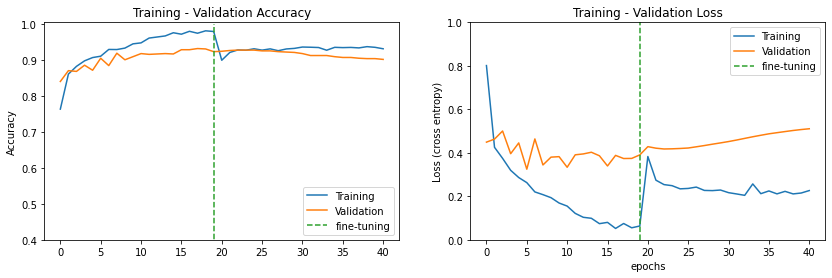

In [53]:
print("\n ------ Learning curve - MobileNetV2 after fine tuning ------ ")
plot_history_fine_tuned(history, history_fine_tuned, epochs_0, loss_max=1)

It can be seen that fine-tuning is improving the accuracy of our model. We note also that the validation loss tends to increase a bit at the end: to prevent an eventual overfitting situation, we could add the `EarlyStopping` function in the callbacks during the training.


### Evaluate

In [54]:
# Evaluation on the test dataset
start = datetime.datetime.now()
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
end = datetime.datetime.now()

print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.40
Test accuracy: 90.89%


In [55]:
printTime(start,end)

 
Total time: 
---------------
 0h 0m 1s


In [56]:
start = datetime.datetime.now()

### Save the model

In [57]:
model.save(checkpoint_filepath2)

###  Predict

In [58]:
import seaborn as sns
from sklearn import metrics

start = datetime.datetime.now()
pred = model.predict(eval_datagen, verbose=1)
end = datetime.datetime.now()

# get most likely class
y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

37/37 [==============================] - 2s 38ms/step


In [59]:
printTime(start,end)

 
Total time: 
---------------
 0h 0m 2s


#### Confusion matrix


 ------ Confusion matrix - MobileNetV2 after fine tuning ------


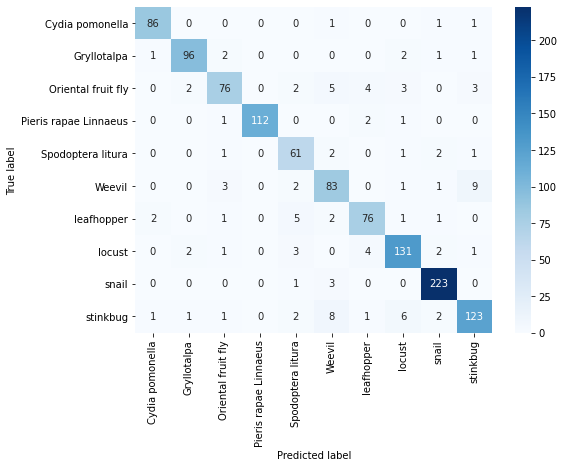

In [60]:
print("\n ------ Confusion matrix - MobileNetV2 after fine tuning ------")
printCM(y_act,y_pred)

#### Classification report

In [61]:
print("\n ------ Classification Report - MobileNetV2 after fine tuning ------\n")
print(metrics.classification_report(y_act, y_pred))



 ------ Classification Report - MobileNetV2 after fine tuning ------

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        89
           1       0.95      0.93      0.94       103
           2       0.88      0.80      0.84        95
           3       1.00      0.97      0.98       116
           4       0.80      0.90      0.85        68
           5       0.80      0.84      0.82        99
           6       0.87      0.86      0.87        88
           7       0.90      0.91      0.90       144
           8       0.96      0.98      0.97       227
           9       0.88      0.85      0.87       145

    accuracy                           0.91      1174
   macro avg       0.90      0.90      0.90      1174
weighted avg       0.91      0.91      0.91      1174



### 4.2.3 Further Fine Tuning the model

#### Define model

In [62]:
layers = [l for l in model.layers]

for i in range(2, len(layers)):
    model.pop()
# model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu')),
model.add(Dropout(0.5)),
model.add(Dense(num_classes, activation='softmax'))    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,522,442
Non-trainable params: 396,544
_________________________________________________________________


#### Compile model

In [63]:
# Updated learning rate
opt = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

# callbacks = [checkpoint, learning_rate_reduction, early_stop]
callbacks = [checkpoint, lrr]

# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,522,442
Non-trainable params: 396,544
_________________________________________________________________


#### Training the Further fine tuned model

In [64]:
further_fine_tuned_epochs = 20
total_epochs_fine = total_epochs + further_fine_tuned_epochs
# print(total_epochs_fine, further_fine_tuned_epochs,total_epochs)

start = datetime.datetime.now()
history_further_fine_tuned = model.fit_generator(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=total_epochs_fine,
    initial_epoch=history_fine_tuned.epoch[-1],
    validation_data=valid_gen,
     validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)
end = datetime.datetime.now()


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 40/60
117/117 [==============================] - 42s 326ms/step - loss: 1.3367 - accuracy: 0.5626 - val_loss: 0.3702 - val_accuracy: 0.8922

Epoch 00040: val_accuracy did not improve from 0.93211
Epoch 41/60
117/117 [==============================] - 37s 315ms/step - loss: 0.3118 - accuracy: 0.9045 - val_loss: 0.3092 - val_accuracy: 0.9062

Epoch 00041: val_accuracy did not improve from 0.93211
Epoch 42/60
117/117 [==============================] - 37s 312ms/step - loss: 0.1999 - accuracy: 0.9430 - val_loss: 0.3826 - val_accuracy: 0.8912

Epoch 00042: val_accuracy did not improve from 0.93211
Epoch 43/60
117/117 [==============================] - 37s 317ms/step - loss: 0.1479 - accuracy: 0.9560 - val_loss: 0.3156 - val_accuracy: 0.9192

Epoch 00043: val_accuracy did not improve from 0.93211
Epoch 44/60
117/117 [==============================] - 37s 315ms/step - loss: 0.1144 - accuracy: 0.9662 - val_loss: 0.3638 - val_accuracy: 0.9052

Epoch 00044: val_accuracy did not improve fro

In [65]:
printTime(start,end)

 
Total time: 
---------------
 0h 12m 47s



 ------ Learning curve - MobileNetV2 after further fine tuning ------


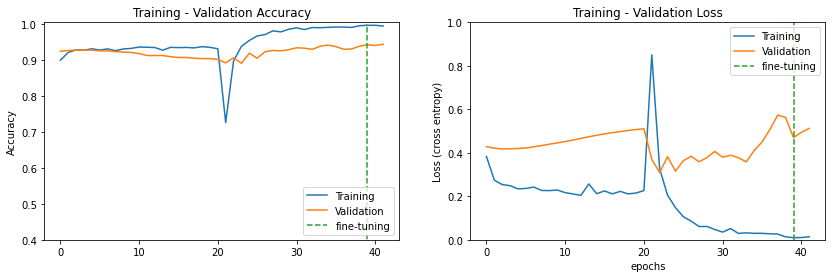

In [66]:
print("\n ------ Learning curve - MobileNetV2 after further fine tuning ------")
plot_history_fine_tuned(history_fine_tuned, history_further_fine_tuned, total_epochs, loss_max=1)

#### Evaluate

In [67]:
# Evaluation on the test dataset
start = datetime.datetime.now()
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
end = datetime.datetime.now()

print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.42
Test accuracy: 94.29%


In [68]:
printTime(start,end)

 
Total time: 
---------------
 0h 0m 1s


In [69]:
model.save(checkpoint_filepath3)

#### Predict

In [70]:
import seaborn as sns
from sklearn import metrics

start = datetime.datetime.now()
pred = model.predict(eval_datagen, verbose=1)
end = datetime.datetime.now()

# get most likely class using argmax function
y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

37/37 [==============================] - 2s 37ms/step


In [71]:
printTime(start,end)

 
Total time: 
---------------
 0h 0m 1s


#### Confusion matrix


 ------ Confusion Matrix - MobileNetV2 after further fine tuning ------ 


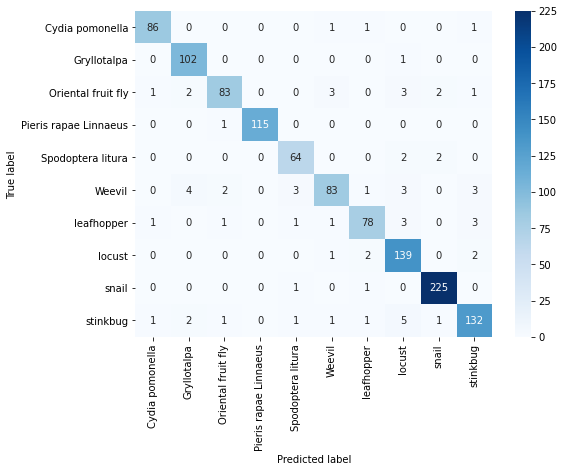

In [72]:
print("\n ------ Confusion Matrix - MobileNetV2 after further fine tuning ------ ")
printCM(y_act,y_pred)

#### classification report

In [73]:
print(" ------ Classification Report - MobileNetV2 after further fine tuning ------\n ")
print(metrics.classification_report(y_act, y_pred))

 ------ Classification Report - MobileNetV2 after further fine tuning ------
 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.93      0.99      0.96       103
           2       0.94      0.87      0.91        95
           3       1.00      0.99      1.00       116
           4       0.91      0.94      0.93        68
           5       0.92      0.84      0.88        99
           6       0.93      0.89      0.91        88
           7       0.89      0.97      0.93       144
           8       0.98      0.99      0.98       227
           9       0.93      0.91      0.92       145

    accuracy                           0.94      1174
   macro avg       0.94      0.94      0.94      1174
weighted avg       0.94      0.94      0.94      1174



<a id="content5"></a>
## 5. Prediction vizualisations

#### Printing predictions

Text(0.5, 0.98, 'Predicted pests; Incorrect Labels in Red - MobileNetV2')

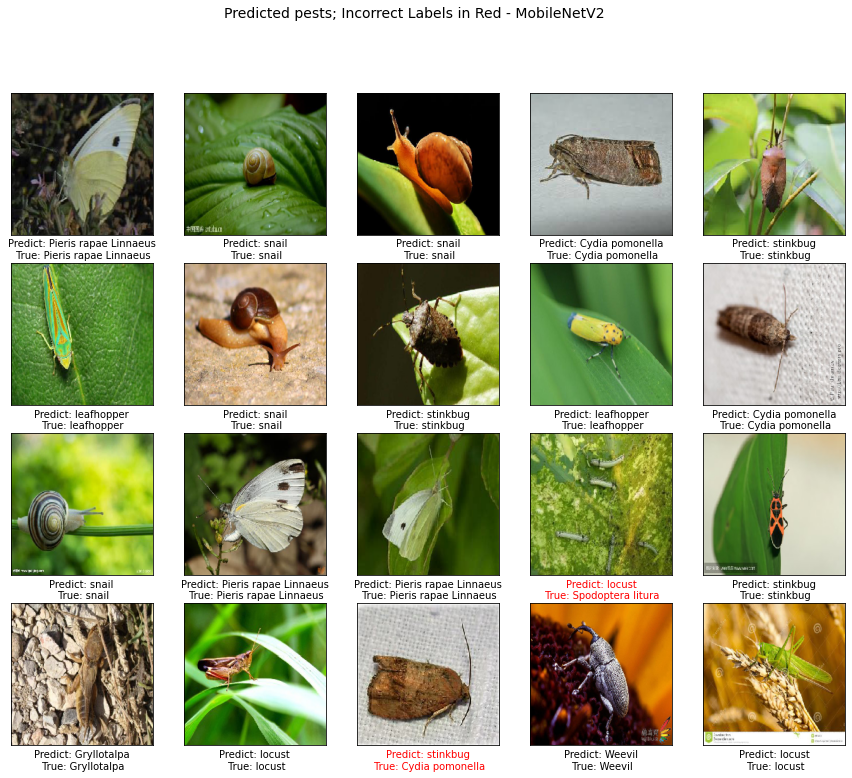

In [74]:
N = 20  # number of pests to display
fig, axes = plt.subplots(4, 5, figsize=(15,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_act[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')

#fig.tight_layout()
fig.suptitle('Predicted pests; Incorrect Labels in Red - MobileNetV2', size=14)

<a id="content6"></a>
## 6. Conclusion

We can note the improvement of the model predictions by doing some fine-tuning. Of course, we can further experiment with the hyperparameters and/or adding other layers on top of the top-less MobileNetV2 base model such as several `Dense` layers with some `Dropout` or `BatchNormalization` ones between (to avoid overfitting). 
